# Exercise 3: Random Forests—Bagging, OOB Error, and Feature Importance

**Goal:**
1. Load and preprocess the Adult income dataset.  
2. Train a single Decision Tree and evaluate.  
3. Train a Random Forest with OOB estimation.  
4. Plot OOB error vs number of trees.  
5. Extract and visualize feature importances.

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
sns.set()


## 2. Load & Preprocess the Adult Income Dataset

- We fetch the `adult` dataset from OpenML.  
- Target: `class` (>50K or <=50K).  
- We one-hot encode categorical features.

In [2]:
# fetch as pandas DataFrame
adult = fetch_openml('adult', version=2, as_frame=True)
df = adult.frame.copy()

# drop rows with missing
df = df.replace('?', np.nan).dropna()

# separate X and y
X = df.drop('class', axis=1)
y = df['class'].apply(lambda s: 1 if s.strip() == '>50K' else 0)

print('Raw shape:', df.shape)
display(df.head())

Raw shape: (45222, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


### 2.1 One-hot encoding

In [3]:
X_enc = pd.get_dummies(X, drop_first=True)
print('After encoding shape:', X_enc.shape)
X_enc.head()

After encoding shape: (45222, 97)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,0,0,40,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,38,89814,9,0,0,50,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,28,336951,12,0,0,40,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,44,160323,10,7688,0,40,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
5,34,198693,6,0,0,30,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


### 2.2 Train/Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42, stratify=y)
print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])

Train size: 36177 Test size: 9045


## 3. Single Decision Tree Baseline

Decision Tree Test Accuracy: 0.808


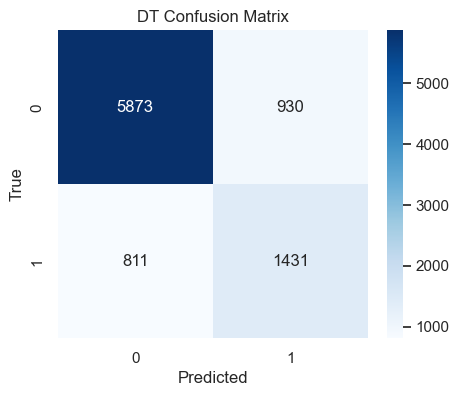

In [5]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Test Accuracy: {acc_dt:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DT Confusion Matrix')
plt.show()

## 4. Random Forest with OOB Estimate

In [6]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

train_acc_rf = rf.score(X_train, y_train)
test_acc_rf = rf.score(X_test, y_test)
oob_acc = rf.oob_score_

print(f"RF Train Acc: {train_acc_rf:.3f}")
print(f"RF Test Acc:  {test_acc_rf:.3f}")
print(f"RF OOB  Acc:  {oob_acc:.3f}")

RF Train Acc: 1.000
RF Test Acc:  0.846
RF OOB  Acc:  0.850


### 4.1 OOB Error vs Number of Trees

/home/z3538568/miniconda3/envs/python/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/z3538568/miniconda3/envs/python/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


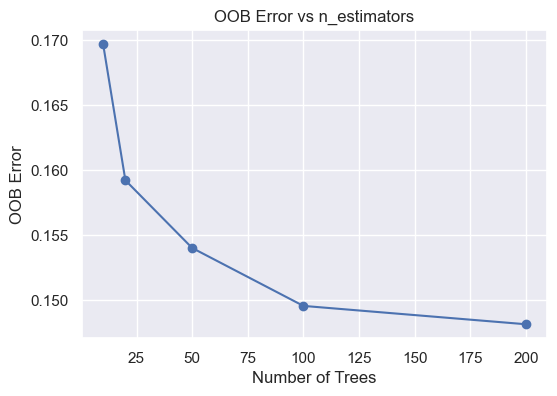

In [7]:
oob_errors = []
n_list = [10, 20, 50, 100, 200]
for n in n_list:
    rf_i = RandomForestClassifier(
        n_estimators=n,
        max_features='sqrt',
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    rf_i.fit(X_train, y_train)
    oob_errors.append(1 - rf_i.oob_score_)

plt.figure(figsize=(6,4))
plt.plot(n_list, oob_errors, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.title('OOB Error vs n_estimators')
plt.show()

## 5. Feature Importances

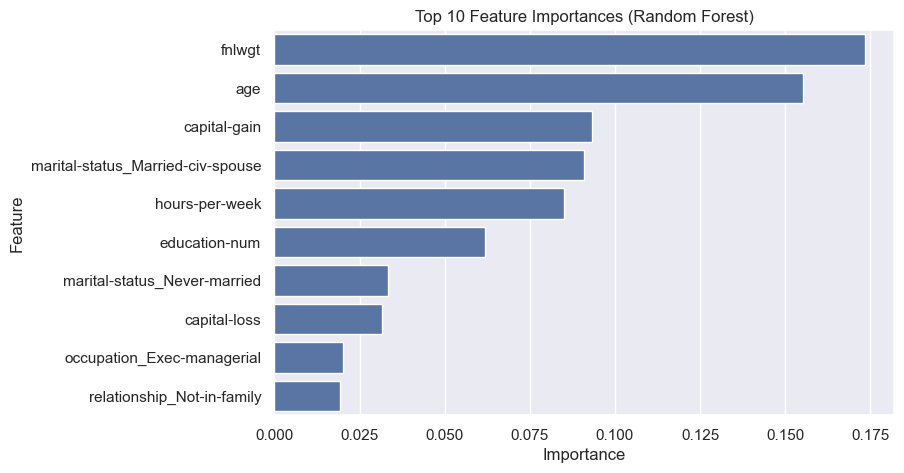

In [8]:
# get importances from the 100-tree forest
importances = rf.feature_importances_
feat_names = X_enc.columns
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8,5))
sns.barplot(x=importances[indices], y=feat_names[indices])
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Key Takeaways

- A single decision tree achieved ~80–82% test accuracy.  
- Random forest boosted accuracy and provided an **OOB** estimate close to test accuracy.  
- OOB error decreases as we add more trees (diminishing returns).  
- Feature importances reveal the top predictors of >50K income.  

Next, you can experiment with changing `max_features`, `max_depth`, or implementing a manual bagging ensemble.